# Sentiment Analysis Model 

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings ('ignore')
import nltk
import re

# Initial Exploratory Data Analysis

In [2]:
data = pd.read_csv(r'train.csv', encoding='utf-8')

In [3]:
data.shape

(17494, 5)

1    9968
0    7526
Name: user_suggestion, dtype: int64


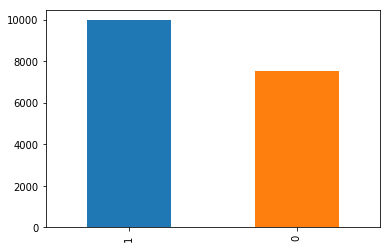

In [4]:
print(data['user_suggestion'].value_counts())
data['user_suggestion'].value_counts().plot.bar()

In [5]:
data.head(10)

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
5,6,Spooky's Jump Scare Mansion,2015.0,"Early Access ReviewIt's pretty cute at first, ...",1
6,7,Spooky's Jump Scare Mansion,2017.0,Great game. it's a cute little horror game tha...,1
7,8,Spooky's Jump Scare Mansion,2015.0,Spooky's Jump Scare Mansion is a Free Retro ma...,1
8,9,Spooky's Jump Scare Mansion,2015.0,"Somewhere between light hearted, happy parody ...",0
9,10,Spooky's Jump Scare Mansion,2015.0,This game with its cute little out of the wall...,1


# Plotting The Initial WordCloud From The Overall Data

In [6]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [7]:
from gensim import utils

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    return s

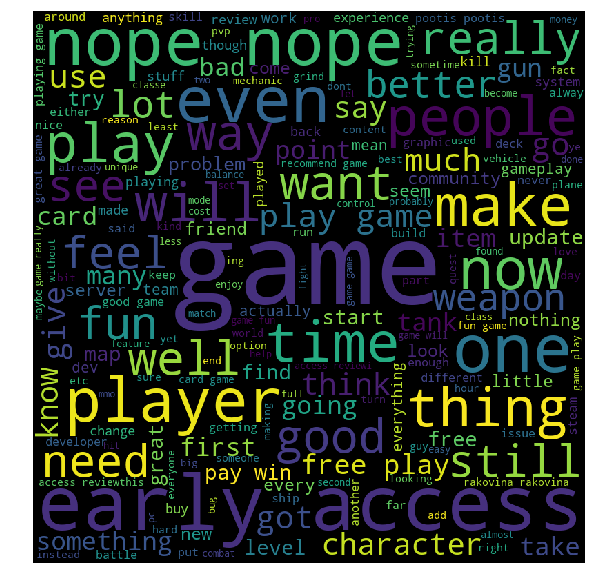

In [8]:
texts = ''
for index, item in data.iterrows():
    texts = texts + ' ' + clean_text(item['user_review'])
    
plot_word_cloud(texts)

#### Since there is no preprocessing yet done, many insignificant words are showing up. We will plot wordcloud for each category after pre processing

# Data Pre-Processing Starts Here....

In [9]:
# Removing URL's 
data['text'] = data['user_review'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [10]:
processed = data['user_review']

In [11]:
qmarks = np.mean(processed.apply(lambda x: '?' in x))
print('Questions with question marks: {:.2f}%'.format(qmarks * 100))

Questions with question marks: 17.03%


In [12]:
# change words to lower case
processed = processed.str.lower()

In [13]:
# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [14]:
#Correcting Letter Repetitions
import re
def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
#%%
processed = processed.apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

In [15]:
# importing Stemmer and Lemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [16]:
# Applying Stemming

#lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
corpus = processed.apply(lambda x: ' '.join(
    stemmer.stem(term) for term in x.split()))

In [17]:
# Removing all the words with length less than 3
processed = corpus.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Feature Extraction and Model Building

In [18]:
#Encoding output labels
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.user_suggestion.values)

In [19]:
# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed, y, stratify=y, random_state=42, test_size=0.30, shuffle=True)

In [20]:
len(X_train)

12245

In [21]:
# Extracting Count Vectors Parameters
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word', ngram_range=(1,2))
count_vect.fit(processed)
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
from sklearn import naive_bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_count, y_train)
y_pred = Naive.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))

lsvm using count vectors accuracy 0.861878453038674


# Results and Evaluation

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( y_val, y_pred)
print(len(X_val))

5249


In [25]:
# 0 = Negative, 1 = Neutral, 2 = Positive
# 0 = Anger, 1 = Anticipation, 2 = Disgust, 3 = Fear, 4 = Joy, 5 = Neutral, 6 = Sadness, 7 = Surprise, 8 = Trust
cm

array([[1855,  403],
       [ 322, 2669]], dtype=int64)

In [26]:
# 0 = Negative, 1 = Neutral, 2 = Positive
# 0 = Anger, 1 = Anticipation, 2 = Disgust, 3 = Fear, 4 = Joy, 5 = Neutral, 6 = Sadness, 7 = Surprise, 8 = Trust
from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2258
           1       0.87      0.89      0.88      2991

   micro avg       0.86      0.86      0.86      5249
   macro avg       0.86      0.86      0.86      5249
weighted avg       0.86      0.86      0.86      5249



# Creating The Pipeline

### Since Now we know that Naive Bayes is thebest model, we will now load the exact same Counter Vectorizer and Naive Bayes HyperParameters to the Pipeline so that we can export it to the pickle file

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

In [28]:
vec = count_vect
 # After doing the hyperparameter tuning from Gridsearch CV Below
pac_clf = naive_bayes.MultinomialNB()
#RandomForestClassifier(n_estimators= 100, criterion='entropy') #83.98
#SGDClassifier(loss = "modified_huber", alpha=0.001, random_state=5, max_iter=25, tol=None, penalty='elasticnet') #83.59
vec_clf = Pipeline([('vectorizer', vec), ('pac', pac_clf)])

In [29]:
vec_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('pac', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [30]:
# Verifying if the model is giving the same accuracy as above or not
vec_clf.score(X_val, y_val)
#Exactly the Same Accuracy

0.8624499904743761

In [31]:
# Fitting the model to all the dataset
vec_clf.fit(processed, y)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('pac', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [32]:
# Saving the model configuration in the pickle file
joblib.dump(vec_clf, 'NLP_Model.pkl')

['NLP_Model.pkl']

In [33]:
def sentiment_classifier(raw_text):
    #Converting the text into lowercase
    processed = str(raw_text).lower()
    #print(processed)
    #Changing the list to series
    processed = pd.Series(processed)

     # Remove punctuation
    processed = processed.str.replace(r'[^\w\d\s]', ' ')
     # Replace whitespace between terms with a single space
    processed = processed.str.replace(r'\s+', ' ')

     # Remove leading and trailing whitespace
    processed = processed.str.replace(r'^\s+|\s+?$', '')

     #Correcting Letter Repetitions
    import re
    def de_repeat(text):
        pattern = re.compile(r"(.)\1{2,}")
        return pattern.sub(r"\1\1", text)
     #%%
    processed = processed.apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

     #Applying Stemmer
    stemmer = PorterStemmer()
    corpus = processed.apply(lambda x: ' '.join(
        stemmer.stem(term) for term in x.split()))


    #Loading the Model
    classifier = joblib.load('NLP_Model.pkl')
    #Classifying the processed text
    predict = classifier.predict(processed)
    predict = int(predict)
    # Mapping the output
    if predict == 0:
        sentiment = "NEGATIVE"
    else:
        sentiment = "POSITIVE"

    #Confidence score of the prediction a.k.a probability score
    probability = classifier.predict_proba(processed)

    y_proba = {}
    for prob in probability:
        y_proba['negative'] = prob[0]
        y_proba['positive'] = prob[1]
            
    
    return sentiment,y_proba

In [34]:
from sklearn.externals import joblib

In [35]:
result,probabilty = sentiment_classifier('this is good')

In [36]:
sentiment_classifier('this is good')[0]

'POSITIVE'